Here are the libraries to be installed before using this code. Use `pip install` to install the following libraries: <br>
```
biopython
matplotlib
playwright
```

In [1]:
from Bio.PDB import PDBParser
import time
import scipy
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import csv

This function downloads the conservation score of a specific pdb file from using __[Consurf Database](https://consurfdb.tau.ac.il/)__. <br>

Input: `pdb_file_path`, `chain_id` (e.g. A, B, C, D) and `protein_id` (e.g. 2PE4)<br>
Output: Folder named "<protein_id>_conservation_scores." Each conservation score file is named with its respective PDB ID.

In [2]:
import asyncio
import os
import re
from playwright.async_api import async_playwright

def download_conservation_scores(pdb_file_path, protein_id, chains):
    """
    Downloads conservation score from Consurf Database using specific PDB file

    Input:
    - pdb_file_path (str): Path to PDB file
    - protein_id (str): Protein ID
    - chains (str): Chain ID
    
    Output:
    - Folder with conservation score in txt format, file named with PDB ID 
    
    """
    pattern = r'pdb(\w+)\.pdb'
    pdb_ids = [match.group(1).upper() for file_path in pdb_file_path if (match := re.search(pattern, file_path))]
    print(pdb_ids)
    
    # Ensure the directory for saving files exists
    output_dir =f"{protein_id}_outputs/{protein_id}_conservation_scores"
    os.makedirs(output_dir, exist_ok=True)

    async def scrape_consurf(pdb_id, chain):
        url = f"https://consurfdb.tau.ac.il/DB/{pdb_id.upper()}{chain}/{pdb_id.upper()}{chain}_consurf_summary.txt"
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page()
            try:
                await page.goto(url, timeout=60000)  # Increase timeout to 60 seconds
                content = await page.content()  # Get the content of the page
                if "Page not found" in content:
                    print(f"Error: Page not found for {pdb_id} chain {chain}")
                    return None
                else:
                    content = await page.text_content("body")  # Get the text content directly from the body
                    if content and "Page not found" not in content:
                        file_path = f"{output_dir}/{pdb_id}_consurf_summary.txt"
                        with open(file_path, "w") as file:
                            file.write(content)
                        print(f"Summary for {pdb_id} chain {chain} saved successfully at {file_path}.")
                        return content
                    else:
                        print(f"Content for {pdb_id} chain {chain} not found or invalid.")
                        return None
            except Exception as e:
                print(f"Error processing {pdb_id} chain {chain}: {e}")
                return None
            finally:
                await browser.close()

    async def main():
        tasks = []
        for pdb_id in pdb_ids:
            for chain in chains:
                tasks.append(scrape_consurf(pdb_id, chain))
        
        # Run all tasks concurrently and gather their results
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        for pdb_id, result in zip(pdb_ids, results):
            if isinstance(result, Exception):
                print(f"Error processing {pdb_id}: {result}")
            elif result:
                print(f"Summary for {pdb_id} saved successfully.")
            else:
                print(f"No content saved for {pdb_id}.")

    # Helper function to run the asyncio code in the correct context
    def run_async_code():
        try:
            loop = asyncio.get_running_loop()
            if loop.is_running():
                return loop.create_task(main())
        except RuntimeError:
            return asyncio.run(main())

    run_async_code()

This function extracts the conservation scores from the downloaded conservation score files and saves the extracted scores as a list, each list item contains 3 dict objects: <i>residue_id</i>, <i>residue_name</i> and <i>conservation_score</i>.

In [3]:
def extract_conservation_score(filename):
    result = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                # Skip header lines and lines below confidence cut-off
                if re.match(r'\s*\d+', line):
                    columns = line.split()
                    pos = int(columns[0])
                    score = float(columns[3])

                    # Check if there is a 3LATOM value, otherwise continue
                    if len(columns) > 6 and ':' in columns[2]:
                        residue_id = re.findall(r'\d+', columns[2])[0]  # Extract numbers from the string
                        residue_id = int(residue_id)  # Convert extracted string to integer
                        residue_name = re.findall(r'[A-Za-z]+', columns[2])[0]  # Extract letters from the string
                        result.append({'residue_id': residue_id, 'residue_name': residue_name, 'conservation_score': score})

        return result
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None


This function reads a PDB file and extracts the 3D spacial coordinates and amino acids.<br>

Input: `pdb_file_path` String, Path to PDB file<br>
Output: `atom_info_list` A list of dictionaries, each dictionary containing information about each atom

In [4]:
def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids.

    Input:
    - pdb_file_path (str): Path to the PDB file

    Output:  
    - A list of dictionaries, each containing information about each atom
    """
    # Create a PDBParser object
    parser = PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id[1],
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)

    return atom_info_list

This function finds the N-neighbours closest to the Alpha Carbon atoms, using brute force with Euclidean distance. <br><br>
Input: `data` List of dictionaries, `angstrom` Float, Distance threshold for neighbour counting <br>
Output: `data` List of dictionaries, containing only 'CA' atoms with `neighbour_count` field and without `model_id`, `atom_name` and `atom_coords` keys

In [6]:
def find_nearest_neighbours(data, angstrom):
    """
    Find the n-neighbors closest to the 'CA' atoms in the data using brute force with Euclidean distance.

    Input:
    - data: list of dictionaries, each containing atom information
    - angstrom (float): distance threshold for neighbour counting

    Output:
    - data: list of dictionaries, containing only 'CA' atoms with updated 'neighbour_count' field,
      and without 'model_id', 'atom_name', and 'atom_coords' keys.
    """

    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms_neighbour = [atom for atom in data if atom.get('chain_id') == 'A' and atom.get('atom_name') == 'CA']
    ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms_neighbour])

    # Calculate distances between 'CA' atoms
    distances = scipy.spatial.distance.cdist(ca_coords, ca_coords, 'euclidean')

    # Use 'residue_id' for DataFrame indexing
    residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms_neighbour)]
    
    # Convert distance matrix to pandas DataFrame
    distance_df = pd.DataFrame(distances, index=residue_ids, columns=residue_ids)

    # Format distance matrix to 3 decimal places
    distance_df = distance_df.round(3)

    # Print the distance matrix
    # print("Distance matrix between CA atoms (formatted to 3 decimal places):")
    # print(distance_df)

    # Count neighbors within a distance of 'angstrom' units for each 'CA' atom
    for index, ca_point in enumerate(ca_coords):
        neighbour_count = np.sum((distances[index] <= angstrom) & (distances[index] != 0))
        ca_atoms_neighbour[index]['neighbour_count'] = neighbour_count

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms_neighbour:
        for key in keys_to_remove:
            atom.pop(key, None)

    return ca_atoms_neighbour


This function finds the hydrophobicity of the amino acid. Hydrophobicity values are taken from the __[IMGT Scale](https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/abbreviation.html)__.<br>

Input: `aa_residue` Dictionary containing `residue_name`<br>
Output: `aa_residue` Dictionary with corresponding `hydrophobicity` information

In [15]:
def find_hydrophobicity(aa_residue):
    """
    Assign hydrophobicity values to an amino acid, using IMGT Scale

    Input:
    - aa_residue: Dict object with 'residue_name'

    Ouput:
    - aa_residue: Dict object with 'hydrophobicity' key
    """
    hydrophobicity_scale = {"ALA": 1.8, "ARG": -4.5, "ASN": -3.5, "ASP": -3.5, "CYS": 2.5, "GLN": -3.5, "GLU": -3.5,
            "GLY": -0.4, "HIS": -3.2, "ILE": 4.5, "LEU": 3.8, "LYS": -3.9, "MET": 1.9, "PHE": 2.8,
            "PRO": -1.6, "SER": -0.8, "THR": -0.7, "TRP": -0.9, "TYR": -1.3, "VAL": 4.2}
        
    if aa_residue["residue_name"] in hydrophobicity_scale:
        aa_residue['hydrophobicity'] = hydrophobicity_scale[aa_residue["residue_name"]]
    else:
        aa_residue['hydrophobicity'] = None
    
    return aa_residue

This function finds the volume of the amino acid. Volume information is taken from the __[IMGT Scale](https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/abbreviation.html)__.<br>

Input: `aa_residue` Dictionary containing `residue_name`<br>
Output: `aa_residue` Dictionary with corresponding `volume` information

In [14]:
def find_volume(aa_residue):
    """
    Assign volume to an amino acid, using IMGT Scale

    Input:
    - aa_residue: Dict object with 'residue_name'

    Ouput:
    - aa_residue: Dict object with 'volume' key
    """
    volume_scale = {"ALA": 88.6, "ARG": 173.4, "ASN": 114.1, "ASP": 111.1, "CYS": 108.5, "GLN": 143.8, "GLU": 138.4,
            "GLY": 60.4, "HIS": 153.2, "ILE": 166.7, "LEU": 166.7, "LYS": 168.6, "MET": 162.9, "PHE": 189.9,
            "PRO": 112.7, "SER": 89.0, "THR": 116.1, "TRP": 227.8, "TYR": 193.6, "VAL": 140.0}
        
    if aa_residue['residue_name'] in volume_scale:
        aa_residue['volume'] = volume_scale[aa_residue['residue_name']]
    else:
        aa_residue['volume'] = None
    
    return aa_residue

This function classifies the proton accepting & donating ability of the amino acids. Amino acids that are non-donors and non-acceptors are given a value of 0, Either Donor or Acceptor is given a value of 1 and Both Donor and Acceptor are given a value of 2.5. Ref from: __[IMGT](https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/charge/index.html#hydrogen)__ <br>

Input: `aa_residue` Dictionary containing `residue_name`<br>
Output: `aa_residue` Dictionary with corresponding `proton_donor` information

In [7]:
def find_proton_donor(aa_residue):
    """
    Classifies amino acid based on proton accepting/donating ability

    Input:
    - aa_residue: Dict object with 'residue_name'

    Ouput:
    - aa_residue: Dict object with 'proton_donor' key
    """
    # Protons donor given 1, Protons acceptors given 1, Both donor and acceptor given 2.5, Neither donor nor receiver given 0
    proton_scale = {"ALA": 0, "ARG": 1, "ASN": 2.5, "ASP": 1, "CYS": 0, "GLN": 2.5, "GLU": 1,
            "GLY": 0, "HIS": 2.5, "ILE": 0, "LEU": 0, "LYS": 1, "MET": 0, "PHE": 0,
            "PRO": 0, "SER": 2.5, "THR": 2.5, "TRP": 1, "TYR": 2.5, "VAL": 0}
        
    if aa_residue['residue_name'] in proton_scale:
        aa_residue['proton_donor'] = proton_scale[aa_residue['residue_name']]
    else:
        aa_residue['proton_donor'] = None
    
    return aa_residue

This function merges the `neighbour_count` and `conservation_score` information. It then calls the `find_hydrophobicity`, `find_volume` and `find_proton_donor` functions to assign the respective information to each residue. <br>

Input: `conservation_scores` List of Dictionaries with Conservation Score, `neighbour_counts` List of Dictionaries with Neighbour Count<br>
Output: `merged_data` List of Dictionaries with `residue_id`, `residue_name`, `conservation_score`, `neighbour_count`, `hydrophobicity`, `volume` and `proton_donor`.

In [8]:
def merge_residue_data(conservation_scores, neighbour_counts):
    """
    Merges conservation score and neighbour count, then assigns hydrophobicity, volume and proton donor/acceptor
    
    Input:
    - conservation_scores: List of dictionaries with conservation score
    - neighbour_counts: List of dictionaries with neighbour count

    Output:
    - merged_data: List of dictionaries with residue id, residue name, consevation score, neighbour count, hydrophobicity, volume and proton donor/acceptor
    """
    # Create a dictionary to index the neighbour_counts by residue_id and residue_name
    neighbour_dict = {(item['residue_id'], item['residue_name']): item for item in neighbour_counts}
    conservation_dict = {(item['residue_id'], item['residue_name']): item for item in conservation_scores}

    # Determine all unique residue identifiers
    all_residues = set(neighbour_dict.keys()).union(conservation_dict.keys())

    # List to hold merged data
    merged_data = []
    
    # Merge data from conservation_scores with neighbour_counts
    for residue_id, residue_name in all_residues:
        merged_entry = {
            'residue_id': residue_id,
            'residue_name': residue_name,
            'conservation_score': conservation_dict.get((residue_id, residue_name), {}).get('conservation_score'),
            'neighbour_count': neighbour_dict.get((residue_id, residue_name), {}).get('neighbour_count')
        }
        find_hydrophobicity(merged_entry)
        find_volume(merged_entry)
        find_proton_donor(merged_entry)

        merged_data.append(merged_entry)
    
    # Sort the merged data by residue_id
    merged_data.sort(key=lambda x: x['residue_id'])

    return merged_data


This function calls `extract_pdb_info`, `find_nearest_neighbors`. `extract_conservation_score` and `merge_residue_data`<br>

Input: `pdb_file_path`, `angstrom`, `protein_id`<br>
Ouput: `merged_data` with all the parameters

In [9]:
def pdb_to_compiled_vector(pdb_file_path, angstrom, protein_id):
    """
    For each pdb sequence, outputs the combined data with all 5 parameters

    Input:
    - pdb_file_path (str): Path to the PDB file
    - angstrom: float, distance threshold for neighbour counting
    - protein_id (str): Protein ID

    Output:
    - merged_residues: List of dictionaries with with residue id, residue name, consevation score, neighbour count, hydrophobicity, volume and proton donor/acceptor
    """
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()

    atom_info_list = extract_pdb_info(pdb_file_path)
    
    neighbour_count = find_nearest_neighbours(atom_info_list, angstrom)
    
    print(f"Number of Amino Acids ({title}): {len(neighbour_count)}")
    
    conservation_scores = extract_conservation_score(filename=f"{protein_id}_outputs/{protein_id}_conservation_scores/{title}_consurf_summary.txt")

    if conservation_scores is not None:
        merged_residues = merge_residue_data(conservation_scores, neighbour_count)
        print(f"Merged Residue ({title}):{merged_residues}")
    else:
        print(f"Conservation scores not found for {title}, skipping merge_residue_data.")
        merged_residues = merge_residue_data([], neighbour_count)

    return merged_residues

This function updates the consensus sequence with the information extracted from the PDB file. `neighbour_count` and `conservation_score` fields are updated. <br>

Input: `ref_seq` Consensus Sequence from __(https://alphafold.ebi.ac.uk/)__ with complete sequence, `Completed` Processed pdb file to be updated to `ref_seq` <br>
Output: `updated_ref_seq`

In [10]:
def merge_to_ref_seq(ref_seq, completed):
    """
    Updates cosesnsus sequence with information extracted from PDB file
    
    Input:
    - ref_seq (str): File path to consensus sequence
    - completed (dict): Processed pdb file to be updates to ref_seq

    Output:
    - updated_ref_seq: List of dictionaries 
    
    """
    # Convert ref_seq to dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}

    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'neighbour_count' in entry:
                ref_seq_entry['neighbour_count'] = entry['neighbour_count']
            if 'conservation_score' in entry and entry['conservation_score'] is not None:
                ref_seq_entry['conservation_score'] = entry['conservation_score']
            #if 'hydrophobicity' in entry:
            #    ref_seq_entry['hydrophobicity'] = entry['hydrophobicity']
            #if 'volume' in entry:
            #    ref_seq_entry['volume'] = entry['volume']   
            #if 'proton_donor' in entry:
            #    ref_seq_entry['proton_donor'] = entry['proton_donor']                      
        else:
            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'neighbour_count': entry.get('neighbour_count', 0),
                'conservation_score': entry.get('conservation_score'),
                'hydrophobicity': entry.get('hydrophobicity'),
                'volume':entry.get('volume'),
                'proton_donor': entry.get('proton_donor')
            }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())
    
    return updated_ref_seq

This function plots `neighbour_counts` and `conservation_scores` on the same plot, with `residue_id` as the x-axis. It also calculates the correlation between `neighbour_counts` and `conservation_scores`.

Input: `data` List of dictionaries of residues, `angstrom`, `protein_id`, `num_residues`<br>
Ouput: Scatter Plot containing `neighbour_counts` and `conservation_scores`

In [11]:
def plot_and_calculate_correlation(data, angstrom, protein_id, num_residues):
    """
    Plots neighbout count and conservation scores for all residues

    Input: 
    - data: List of dictionaries
    - angstrom
    - protein_id
    - num_residues

    Output:
    - scatter plot: y axes are neighbour count and conservation score, x axis is residue id
    - caculated correlation between neighbour counts and conservations scores
    """
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    neighbour_counts = [entry['neighbour_count'] for entry in data]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot neighbour counts
    plt.scatter(residue_ids, neighbour_counts, color='green', label='Neighbour Count')
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        plt.scatter(valid_residue_ids, conservation_scores, color='blue', label='Conservation Score')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")

    plt.xlabel('Residue ID')
    plt.ylabel('Score / Count')
    plt.title(f'{protein_id} Complete: Residue ID vs Conservation Score and Neighbour Count ({angstrom}A)')
    plt.legend()
    
    # Set plot limits for residue IDs
    plt.xlim(0, num_residues)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


This function plots the different parameters of individual residues as a horizontal bar chart. The x-axis is the `residue_id` and y-axis plots `hydrophobicity`, `neighbour_count`, `conservation_score`, `volume` and `proton_donor` values. A legend is provided below for identification. <br>

Input: `data` List of dictionaries containing residue properties, `protein_id`, `num_residues` <br>
Output: Summary Chart with the 5 parameters

In [19]:
def plot_residue_properties(data, protein_id, num_residues=None):
    # Limit the data to the specified number of residues
    if num_residues is not None:
        data = data[:num_residues]

    # Extract data for plotting and replace None with 0
    residue_ids = [entry['residue_id'] for entry in data]
    hydrophobicities = [entry.get('hydrophobicity', 0) or 0 for entry in data]
    conservation_scores = [entry.get('conservation_score', 0) or 0 for entry in data]
    neighbour_counts = [entry.get('neighbour_count', 0) or 0 for entry in data]
    volumes = [entry.get('volume', 0) or 0 for entry in data]
    proton_donors = [entry.get('proton_donor', 0) or 0 for entry in data]

    # Handle cases where lists might be empty
    min_hydrophobicity = min(hydrophobicities)
    max_hydrophobicity = max(hydrophobicities)
    min_conservation = min(conservation_scores)
    max_conservation = max(conservation_scores)
    min_neighbour = min(neighbour_counts)
    max_neighbour = max(neighbour_counts)
    min_volume = min(volumes)
    max_volume = max(volumes)
    min_proton = min(proton_donors)
    max_proton = max(proton_donors)

    norm_hydrophobicity = mcolors.Normalize(vmin=min_hydrophobicity, vmax=max_hydrophobicity)
    norm_conservation = mcolors.Normalize(vmin=min_conservation, vmax=max_conservation)
    norm_neighbour = mcolors.Normalize(vmin=min_neighbour, vmax=max_neighbour)
    norm_volume = mcolors.Normalize(vmin=min_volume, vmax=max_volume)
    norm_proton = mcolors.Normalize(vmin=min_proton, vmax=max_proton)


    cmap = plt.cm.coolwarm  # You can choose any colormap you prefer

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 3))

    # Set the title of the plot
    plt.title(f'Summary of {protein_id} Properties')

    # Plot proton donors/ acceptors 
    for i, proton_donor in enumerate(proton_donors):
        ax.barh(4.5, 1, left=i, color=cmap(norm_proton(proton_donor)), edgecolor='none', height=1)

    # Plot volume    
    for i, volume in enumerate(volumes):
        ax.barh(3.5, 1, left=i, color=cmap(norm_volume(volume)), edgecolor='none', height=1)

    # Plot hydrophobicity    
    for i, hydrophobicity in enumerate(hydrophobicities):
        ax.barh(2.5, 1, left=i, color=cmap(norm_hydrophobicity(hydrophobicity)), edgecolor='none', height=1)

    # Plot conservation scores
    for i, score in enumerate(conservation_scores):
        ax.barh(1.5, 1, left=i, color=cmap(norm_conservation(score)), edgecolor='none', height=1)

    # Plot neighbour counts
    for i, count in enumerate(neighbour_counts):
        ax.barh(0.5, 1, left=i, color=cmap(norm_neighbour(count)), edgecolor='none', height=1)

    # Add colorbars to reflect each property
    sm_proton = plt.cm.ScalarMappable(cmap=cmap, norm=norm_proton)
    sm_volume = plt.cm.ScalarMappable(cmap=cmap, norm=norm_volume)
    sm_hydro = plt.cm.ScalarMappable(cmap=cmap, norm=norm_hydrophobicity)
    sm_conserv = plt.cm.ScalarMappable(cmap=cmap, norm=norm_conservation)
    sm_neigh = plt.cm.ScalarMappable(cmap=cmap, norm=norm_neighbour)

    # Create colorbar for each property
    cbar_ax_proton = fig.add_axes([0.1, -0.1, 0.15, 0.03])
    cbar_ax_volume = fig.add_axes([0.3, -0.1, 0.15, 0.03])
    cbar_ax_hydro = fig.add_axes([0.5, -0.1, 0.15, 0.03])
    cbar_ax_conserv = fig.add_axes([0.7, -0.1, 0.15, 0.03])
    cbar_ax_neigh = fig.add_axes([0.9, -0.1, 0.15, 0.03])

    fig.colorbar(sm_proton, cax=cbar_ax_proton, orientation='horizontal', fraction=0.02, pad=0.1, label='Proton Donor/Acceptor')
    fig.colorbar(sm_volume, cax=cbar_ax_volume, orientation='horizontal', fraction=0.02, pad=0.1, label='Volume')
    fig.colorbar(sm_hydro, cax=cbar_ax_hydro, orientation='horizontal', fraction=0.02, pad=0.1, label='Hydrophobicity')
    fig.colorbar(sm_conserv, cax=cbar_ax_conserv, orientation='horizontal', fraction=0.02, pad=0.1, label='Conservation Score')
    fig.colorbar(sm_neigh, cax=cbar_ax_neigh, orientation='horizontal', fraction=0.02, pad=0.1, label='Neighbour Count')

    # Customize plot
    ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
    ax.set_yticklabels(['Neighbour Count', 'Conservation Score', 'Hydrophobicity', 'Volume', 'Proton Donor/Acceptor'])

    # Add x-axis labels for every 100 residues
    x_ticks = range(0, len(residue_ids), 100)
    x_tick_labels = [str(i) for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    plt.tight_layout()
    plt.show()

This function outputs the `merged_data` into a csv file.<br>

Input: `data` List of Dictionaries, `protein_id`<br>
Output: Summarised csv file

In [12]:
def save_to_csv(data, protein_id):
    # Create the output directory if it doesn't exist
    os.makedirs(f'{protein_id}_outputs', exist_ok=True)

    # Create a DataFrame from the data for CSV output
    df = pd.DataFrame(data)
    
    # Save the DataFrame to a CSV file
    output_file = os.path.join(f'{protein_id}_outputs', f'{protein_id}_summary.csv')
    df.to_csv(output_file, index=False)
    
    # Print confirmation
    print(f"Data saved to '{protein_id}'")


This function analyses the different parameters of the protein sequence and gives the `residue_id` of residues that meet the criteria.

In [20]:
def analyse_protein(residues):
    # Function to check criteria
    def meets_criteria(residue):
        criteria_count = 0

        if residue.get('neighbour_count', 0) >= 4:
            criteria_count += 1
        # Skip the conservation_score criterion if it is None
        if residue.get('conservation_score') is not None and residue.get('conservation_score') <= -0.5:
            criteria_count += 1
        if residue.get('hydrophobicity') is not None and (residue.get('hydrophobicity', 0) > 3 or residue.get('hydrophobicity', 0) < -3):
            criteria_count += 1
        if residue.get('proton_donor') is not None and residue.get('proton_donor', 0) > 2:
            criteria_count += 1
        if residue.get('volume') is not None and residue.get('volume', float('inf')) < 120.0:
            criteria_count += 1

        return criteria_count >= 3

    # Find residues that meet the criteria
    qualifying_residues = [residue for residue in residues if meets_criteria(residue)]

    # Sort residues by residue_id
    qualifying_residues.sort(key=lambda x: x['residue_id'])

    # Extract and return the list of amino acids
    amino_acids = [residue['residue_id'] for residue in qualifying_residues]

    # Output the list
    print(f"Number of Amino acids that meet the criteria: {len(amino_acids)}")
    print(amino_acids)

    return amino_acids

In [21]:
def analyse_protein_2(residues, weights, protein_id):
    # Ensure weights sum to 1
    if not np.isclose(sum(weights), 1):
        raise ValueError("Weights must sum to 1.")

    # Extract all parameter values
    neighbour_counts = [residue['neighbour_count'] for residue in residues]
    conservation_scores = [residue['conservation_score'] if residue['conservation_score'] is not None else 0 for residue in residues]
    hydrophobicities = [residue['hydrophobicity']  if residue['hydrophobicity']is not None else 0 for residue in residues]
    h_donors = [residue['proton_donor'] if residue['proton_donor']is not None else 0 for residue in residues]
    volumes = [residue['volume'] if residue['volume']is not None else 0 for residue in residues]

    # Normalization basis
    max_neighbour_count = max(neighbour_counts)
    min_neighbour_count = min(neighbour_counts)

    max_conservation = max(conservation_scores)
    min_conservation = min(conservation_scores)

    max_hydrophobicity = max(abs(h) if not None else 0 for h in hydrophobicities )
    min_hydrophobicity = -max_hydrophobicity

    max_h_donor = max(h_donors)
    min_h_donor = min(h_donors)

    max_volume = max(volumes)
    min_volume = min(volumes)

    # Normalize values
    for residue in residues:
        # Normalized values
        residue['norm_neighbour_count'] = (residue['neighbour_count'] - min_neighbour_count) / (max_neighbour_count - min_neighbour_count) if max_neighbour_count > min_neighbour_count else 0

        residue['norm_conservation_score'] = (
            (max_conservation - residue['conservation_score']) / (max_conservation - min_conservation)
            if residue['conservation_score'] is not None and max_conservation > min_conservation else 0
        )
        # Handle None value for hydrophobicity
        if residue['hydrophobicity'] is not None:
            abs_hydrophobicity = abs(residue['hydrophobicity'])
            residue['norm_hydrophobicity'] = (
                (abs_hydrophobicity - min_hydrophobicity) / (max_hydrophobicity - min_hydrophobicity)
                if max_hydrophobicity > min_hydrophobicity else 0
            )
            residue['norm_hydrophobicity'] = min(residue['norm_hydrophobicity'], 1)  # Ensure the value is not greater than 1
        else:
            residue['norm_hydrophobicity'] = 0  # Default for None values
        
        # Handle None value for proton_donor
        if residue['proton_donor'] is not None:
            residue['norm_proton_donor'] = (
                (residue['proton_donor'] - min_h_donor) / (max_h_donor - min_h_donor)
                if max_h_donor > min_h_donor else 0
            )
        else:
            residue['norm_proton_donor'] = 0  # Default for None values
        
        if residue['volume'] is not None:
            residue['norm_volume'] = (
                (max_volume - residue['volume']) / (max_volume - min_volume) 
                if max_volume > min_volume else 0
            )
        else: residue['norm_volume'] = 0

        # Weighted sum calculation
        residue['weighted_sum'] = (
            residue['norm_neighbour_count'] * weights[0] +
            residue['norm_conservation_score'] * weights[1] +
            residue['norm_hydrophobicity'] * weights[2] +
            residue['norm_proton_donor'] * weights[3] +
            residue['norm_volume'] * weights[4]
        )

    # Sort residues by decreasing weighted sum
    residues.sort(key=lambda x: x['weighted_sum'], reverse=True)

    # Output to CSV
    output_path = f'{protein_id}_outputs/{protein_id}_residue_analysis.csv'
    with open(output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow([
            'Residue ID', 'Residue Name',
            'Norm Neighbour Count', 'Norm Conservation Score', 'Norm Hydrophobicity', 'Norm Proton Donor', 'Norm Volume',
            'Weighted Sum'
        ])
        # Write data
        for residue in residues:
            writer.writerow([
                residue['residue_id'], residue['residue_name'],
                residue['norm_neighbour_count'], residue['norm_conservation_score'], residue['norm_hydrophobicity'],
                residue['norm_proton_donor'], residue['norm_volume'],
                residue['weighted_sum']
            ])

    print("Residue analysis has been written to residue_analysis.csv.")

['2DU2', '2E77', '2J6X', '2NLI', '2ZFA', '4RJE', '4YL2', '5EBU', '7F1Y', '7F20', '7F21', '7F22']
Number of Amino Acids (Q44467-F1-MODEL_V4): 374
Error processing file LOX_outputs/LOX_conservation_scores/Q44467-F1-MODEL_V4_consurf_summary.txt: [Errno 2] No such file or directory: 'LOX_outputs/LOX_conservation_scores/Q44467-F1-MODEL_V4_consurf_summary.txt'
Conservation scores not found for Q44467-F1-MODEL_V4, skipping merge_residue_data.


/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12355.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12386.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12417.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12448.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12479.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBu

Number of Amino Acids (2DU2): 374
Error processing file LOX_outputs/LOX_conservation_scores/2DU2_consurf_summary.txt: list index out of range
Conservation scores not found for 2DU2, skipping merge_residue_data.
Number of Amino Acids (2E77): 356
Error processing file LOX_outputs/LOX_conservation_scores/2E77_consurf_summary.txt: list index out of range
Conservation scores not found for 2E77, skipping merge_residue_data.


/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 23427.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 23458.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 23489.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 23520.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 23552.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBu

Number of Amino Acids (2J6X): 370
Merged Residue (2J6X):[{'residue_id': 5, 'residue_name': 'ASP', 'conservation_score': 0.495, 'neighbour_count': np.int64(1), 'hydrophobicity': -3.5, 'volume': 111.1, 'proton_donor': 1}, {'residue_id': 6, 'residue_name': 'ILE', 'conservation_score': 1.303, 'neighbour_count': np.int64(2), 'hydrophobicity': 4.5, 'volume': 166.7, 'proton_donor': 0}, {'residue_id': 7, 'residue_name': 'GLU', 'conservation_score': 1.801, 'neighbour_count': np.int64(2), 'hydrophobicity': -3.5, 'volume': 138.4, 'proton_donor': 1}, {'residue_id': 8, 'residue_name': 'TYR', 'conservation_score': 0.248, 'neighbour_count': np.int64(2), 'hydrophobicity': -1.3, 'volume': 193.6, 'proton_donor': 2.5}, {'residue_id': 9, 'residue_name': 'ASN', 'conservation_score': 0.896, 'neighbour_count': np.int64(2), 'hydrophobicity': -3.5, 'volume': 114.1, 'proton_donor': 2.5}, {'residue_id': 10, 'residue_name': 'ALA', 'conservation_score': 1.01, 'neighbour_count': np.int64(3), 'hydrophobicity': 1.8, 

/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11960.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12001.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12042.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12083.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12120.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBu

Number of Amino Acids (4RJE): 368
Error processing file LOX_outputs/LOX_conservation_scores/4RJE_consurf_summary.txt: list index out of range
Conservation scores not found for 4RJE, skipping merge_residue_data.
Number of Amino Acids (4YL2): 368
Error processing file LOX_outputs/LOX_conservation_scores/4YL2_consurf_summary.txt: list index out of range
Conservation scores not found for 4YL2, skipping merge_residue_data.


/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 23472.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 23509.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 23546.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 23583.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 23620.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBu

Number of Amino Acids (5EBU): 368
Error processing file LOX_outputs/LOX_conservation_scores/5EBU_consurf_summary.txt: list index out of range
Conservation scores not found for 5EBU, skipping merge_residue_data.
Number of Amino Acids (7F1Y): 352
Error processing file LOX_outputs/LOX_conservation_scores/7F1Y_consurf_summary.txt: list index out of range
Conservation scores not found for 7F1Y, skipping merge_residue_data.
Number of Amino Acids (7F20): 369
Error processing file LOX_outputs/LOX_conservation_scores/7F20_consurf_summary.txt: list index out of range
Conservation scores not found for 7F20, skipping merge_residue_data.
Number of Amino Acids (7F21): 369
Error processing file LOX_outputs/LOX_conservation_scores/7F21_consurf_summary.txt: list index out of range
Conservation scores not found for 7F21, skipping merge_residue_data.
Number of Amino Acids (7F22): 369
Error processing file LOX_outputs/LOX_conservation_scores/7F22_consurf_summary.txt: list index out of range
Conservation s

/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7072.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7109.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7146.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7505.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7096.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder

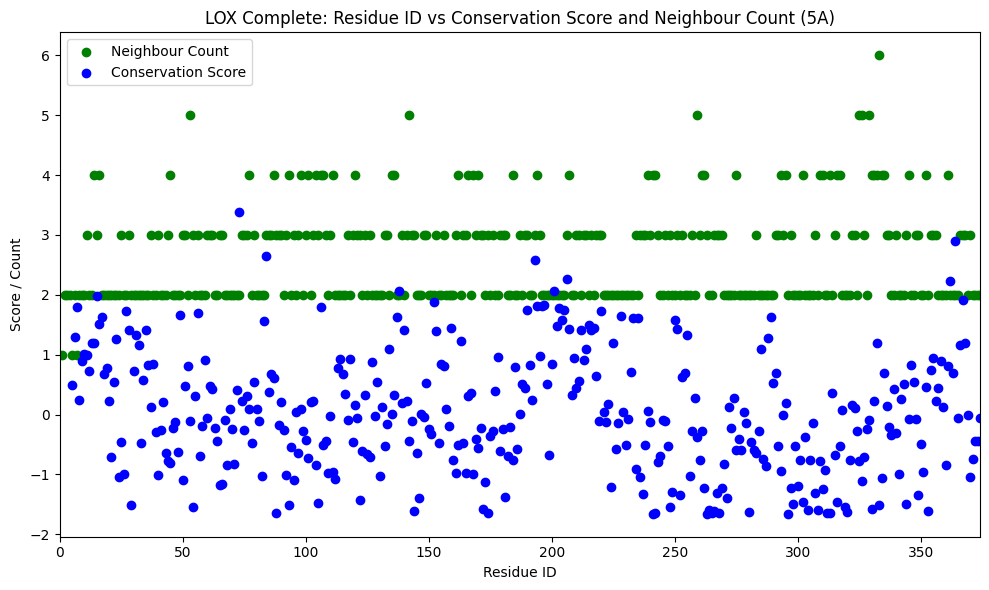

/var/folders/c1/vbqmbhrj0n3gff0pm_xnb7zc0000gn/T/ipykernel_965/2454214137.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


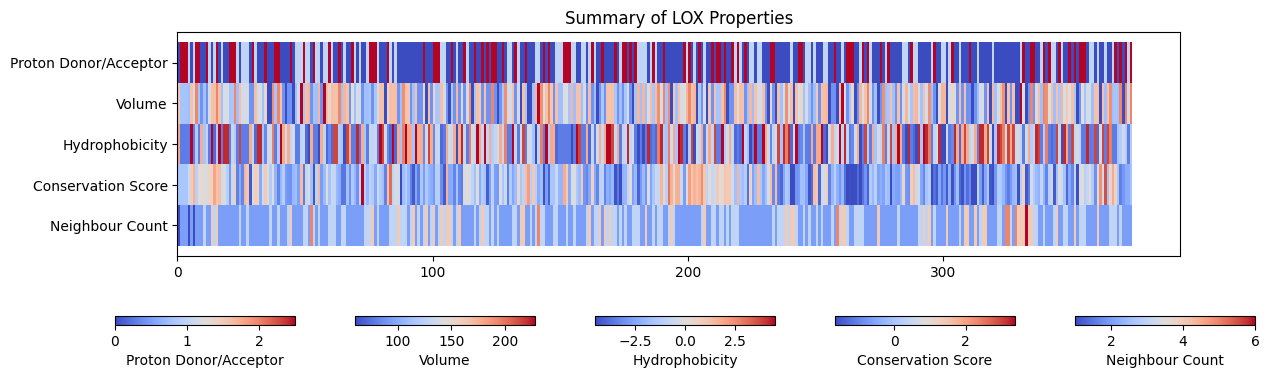

Data saved to 'LOX'
Number of Amino acids that meet the criteria: 69
[2, 3, 4, 9, 21, 24, 39, 45, 50, 54, 77, 93, 97, 101, 104, 107, 111, 120, 122, 125, 137, 144, 154, 162, 168, 170, 172, 174, 180, 182, 184, 187, 199, 212, 213, 226, 234, 241, 242, 244, 248, 262, 263, 264, 265, 269, 275, 288, 293, 296, 297, 302, 304, 309, 310, 311, 313, 316, 317, 325, 326, 330, 332, 333, 334, 344, 352, 356, 368]
Residue analysis has been written to residue_analysis.csv.


Summary for 7F20 chain A saved successfully at LOX_outputs/LOX_conservation_scores/7F20_consurf_summary.txt.
Summary for 2DU2 chain A saved successfully at LOX_outputs/LOX_conservation_scores/2DU2_consurf_summary.txt.
Summary for 5EBU chain A saved successfully at LOX_outputs/LOX_conservation_scores/5EBU_consurf_summary.txt.
Summary for 2NLI chain A saved successfully at LOX_outputs/LOX_conservation_scores/2NLI_consurf_summary.txt.
Summary for 2E77 chain A saved successfully at LOX_outputs/LOX_conservation_scores/2E77_consurf_summary.txt.
Summary for 7F22 chain A saved successfully at LOX_outputs/LOX_conservation_scores/7F22_consurf_summary.txt.
Summary for 7F1Y chain A saved successfully at LOX_outputs/LOX_conservation_scores/7F1Y_consurf_summary.txt.
Summary for 7F21 chain A saved successfully at LOX_outputs/LOX_conservation_scores/7F21_consurf_summary.txt.
Summary for 2ZFA chain A saved successfully at LOX_outputs/LOX_conservation_scores/2ZFA_consurf_summary.txt.
Summary for 4YL2 ch

In [22]:
## This part needs to be edited!

pdb_file_paths = ['./LOX_pdb/pdb2du2.pdb', './LOX_pdb/pdb2e77.pdb', './LOX_pdb/pdb2j6x.pdb', './LOX_pdb/pdb2nli.pdb', './LOX_pdb/pdb2zfa.pdb', './LOX_pdb/pdb4rje.pdb', './LOX_pdb/pdb4yl2.pdb', './LOX_pdb/pdb5ebu.pdb', './LOX_pdb/pdb7f1y.pdb', './LOX_pdb/pdb7f20.pdb', './LOX_pdb/pdb7f21.pdb', './lOX_pdb/pdb7f22.pdb']

ref_seq = './LOX_pdb/AF-Q44467-F1-model_v4.pdb'
protein_id = 'LOX'
num_residues = 374
angstrom = 5
weights = [0.2,0.2,0.2,0.2,0.2]
download_conservation_scores(pdb_file_paths, protein_id, chains=['A'])

#compare_seq(ref_seq_path, pdb_file_paths, protein_id)

ref_seq = pdb_to_compiled_vector(ref_seq, angstrom, protein_id)
#print(f"Ref Seq:{ref_seq}")

for pdb_file in pdb_file_paths:
        completed = pdb_to_compiled_vector(pdb_file, angstrom, protein_id)
        updated_ref_seq = merge_to_ref_seq(ref_seq, completed)

print(f"Updated Seq: {updated_ref_seq}")

plot_and_calculate_correlation(updated_ref_seq, angstrom, protein_id, num_residues)
plot_residue_properties(updated_ref_seq, protein_id, num_residues)
save_to_csv(updated_ref_seq,protein_id)
analyse_protein(updated_ref_seq)
analyse_protein_2(updated_ref_seq, weights, protein_id)
